In [1]:
from sklearn import model_selection
from sklearn import metrics
import os
import numpy as np
import pandas as pd
from MicroBiome import MicroBiomeDataSet, Trainer, TrainTester, MultiTrainTester
from sklearn import linear_model as LM
import seaborn as sns
import pickle as pk
from matplotlib import pyplot as plt


# Ignore warning messages
if True:
    import warnings
    warnings.filterwarnings('ignore')

# Load Data

In [2]:
top_dir = '/project'
data_dir = os.path.join(top_dir, 'data')
preproc_dir = os.path.join(data_dir, 'preprocessed')
inp_dir = os.path.join(preproc_dir, 'Gupta_2020_Precompiled_Cleaned')
out_dir = os.path.join(data_dir, 'results/LogisticRegressionCV_PCA_Healthy_v_ACVD_Jie_v_Rest_Healthy')

In [3]:
os.listdir(inp_dir)

['MatrixDataClean.csv',
 'SampleMetaDataClean.csv',
 'SampleMetaDataManual.csv',
 'FeatMetaDataClean.csv']

In [4]:
MatrixData = np.loadtxt(os.path.join(inp_dir, 'MatrixDataClean.csv'))
MatrixData.shape

(4347, 903)

In [5]:
SampleMeta = pd.read_csv(os.path.join(inp_dir, 'SampleMetaDataClean.csv'))
SampleMeta.shape

(4347, 38)

In [6]:
filter_indices = SampleMeta["Phenotype"].isin(['Healthy'])
SampleMetaFilt = SampleMeta[ filter_indices ]
SampleMetaFilt.shape

(2636, 38)

In [7]:
SampleMetaFilt["Study Accession"].value_counts()

PRJEB11532     883
PRJNA319574    467
PRJNA48479     222
PRJNA328899    107
PRJEB12123     101
PRJEB6337       92
PRJEB6456       89
PRJEB21528      75
PRJNA422434     61
PRJEB1220       58
PRJEB6997       55
PRJEB6070       42
PRJEB4336       39
PRJEB15371      39
PRJEB13870      35
PRJNA305507     33
PRJEB12449      30
PRJNA278393     30
PRJDB3601       26
PRJEB7774       21
PRJNA268964     20
PRJEB8094       19
PRJEB1786       18
PRJNA389280     17
PRJNA373879     16
PRJEB1690       16
PRJEB19090      13
PRJNA177201      8
PRJNA385949      3
PRJNA299502      1
Name: Study Accession, dtype: int64

In [8]:
MatrixDataFilt = MatrixData[ filter_indices ]
MatrixDataFilt.shape

(2636, 903)

In [9]:
FeatMeta = pd.read_csv(os.path.join(inp_dir, 'FeatMetaDataClean.csv'))
FeatMeta

,Unnamed: 0,feature
0,s__Abiotrophia_defectiva,s__Abiotrophia_defectiva
1,s__Acetobacter_unclassified,s__Acetobacter_unclassified
2,s__Achromobacter_piechaudii,s__Achromobacter_piechaudii
3,s__Achromobacter_unclassified,s__Achromobacter_unclassified
4,s__Achromobacter_xylosoxidans,s__Achromobacter_xylosoxidans
...,...,...
898,s__Weissella_koreensis,s__Weissella_koreensis
899,s__Weissella_paramesenteroides,s__Weissella_paramesenteroides
900,s__Weissella_unclassified,s__Weissella_unclassified
901,s__Wohlfahrtiimonas_chitiniclastica,s__Wohlfahrtiimonas_chitiniclastica


In [10]:
X = MatrixDataFilt

In [11]:
y = SampleMetaFilt['Study Accession'].to_numpy() == 'PRJEB21528'
y = y.astype('int64')

In [12]:
pd.value_counts(y)

0    2561
1      75
dtype: int64

# Define and Train Model

In [13]:
def RECALL_SCORE(y_pred, y_true):
    return(metrics.recall_score(y_pred, y_true, average='macro'))

retrain = False
n_splits = 5
out_path = os.path.join(out_dir, 'MyMultiTrainTester.pk')

if retrain:
    # clear previous results, if any
    if os.path.exists(out_dir):
        os.system('rm -rf ' + out_dir)
    os.mkdir(out_dir)
    # random seed here deals with model initialization
    MyLogistic = LM.LogisticRegressionCV(random_state = 42, class_weight='balanced', Cs = np.exp(-np.arange(-10, 10)), 
                                         solver='saga', penalty='elasticnet', l1_ratios=np.arange(0, 1.10, 0.10),
                                        scoring=metrics.make_scorer(RECALL_SCORE))
    MyTrainer = Trainer(model = MyLogistic, scale_X = True, use_pca = True, n_components=100)
    # random seed used in class definition is not used in final output models
    MyTrainTester = TrainTester(MyTrainer, RECALL_SCORE)
    # note that random seed here affects sequence of seeds passed to making new TrainTester objects
    # using LRTrainTester as template. Thus, you have all settings but seed affecting sample split
    # across all data splits
    MyMultiTrainTester = MultiTrainTester(MyTrainTester, numpy_rand_seed = 42, n_splits = n_splits)
    MyMultiTrainTester.train(X, y)
    # save results
    outfile = open(out_path,'wb')
    pk.dump(MyMultiTrainTester, outfile)
    outfile.close()
    
else:
    # load previous results
    infile = open(out_path,'rb')
    MyMultiTrainTester = pk.load(infile)
    infile.close()
    


Running for split 1 of 5
Using predict_proba
getting predictions from probs
Running for split 2 of 5
Using predict_proba
getting predictions from probs
Running for split 3 of 5
Using predict_proba
getting predictions from probs
Running for split 4 of 5
Using predict_proba
getting predictions from probs
Running for split 5 of 5
Using predict_proba
getting predictions from probs


In [14]:
scores_df = pd.DataFrame({'score': MyMultiTrainTester.train_scores, 'stage' : np.repeat('train', n_splits)})
scores_df = scores_df.append(pd.DataFrame({'score': MyMultiTrainTester.test_scores, 'stage' : np.repeat('test', n_splits)}))
scores_df

,score,stage
0,0.574535,train
1,0.613739,train
2,0.567419,train
3,0.585752,train
4,0.576756,train
0,0.566374,test
1,0.547108,test
2,0.572256,test
3,0.564018,test
4,0.557471,test


<AxesSubplot:xlabel='stage', ylabel='score'>

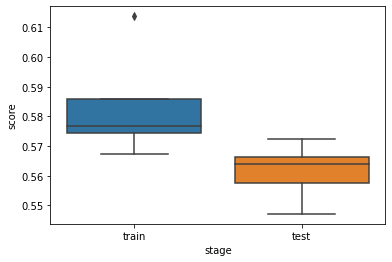

In [15]:
sns.boxplot(data = scores_df, x = 'stage', y = 'score')

In [16]:
MyMultiTrainTester.TrainerList[0].model.Cs_

array([2.20264658e+04, 8.10308393e+03, 2.98095799e+03, 1.09663316e+03,
       4.03428793e+02, 1.48413159e+02, 5.45981500e+01, 2.00855369e+01,
       7.38905610e+00, 2.71828183e+00, 1.00000000e+00, 3.67879441e-01,
       1.35335283e-01, 4.97870684e-02, 1.83156389e-02, 6.73794700e-03,
       2.47875218e-03, 9.11881966e-04, 3.35462628e-04, 1.23409804e-04])

In [17]:
hyperparams = {'l1_ratio': [], 'C': []}
for i in range(n_splits):
    hyperparams['l1_ratio'].append(MyMultiTrainTester.TrainerList[i].model.l1_ratio_)
    hyperparams['C'].append(MyMultiTrainTester.TrainerList[i].model.C_)

In [18]:
pd.DataFrame(hyperparams)

,l1_ratio,C
0,[0.1],[0.0024787521766663585]
1,[0.7000000000000001],[0.049787068367863944]
2,[0.2],[0.0024787521766663585]
3,[0.0],[0.0024787521766663585]
4,[0.5],[0.006737946999085467]


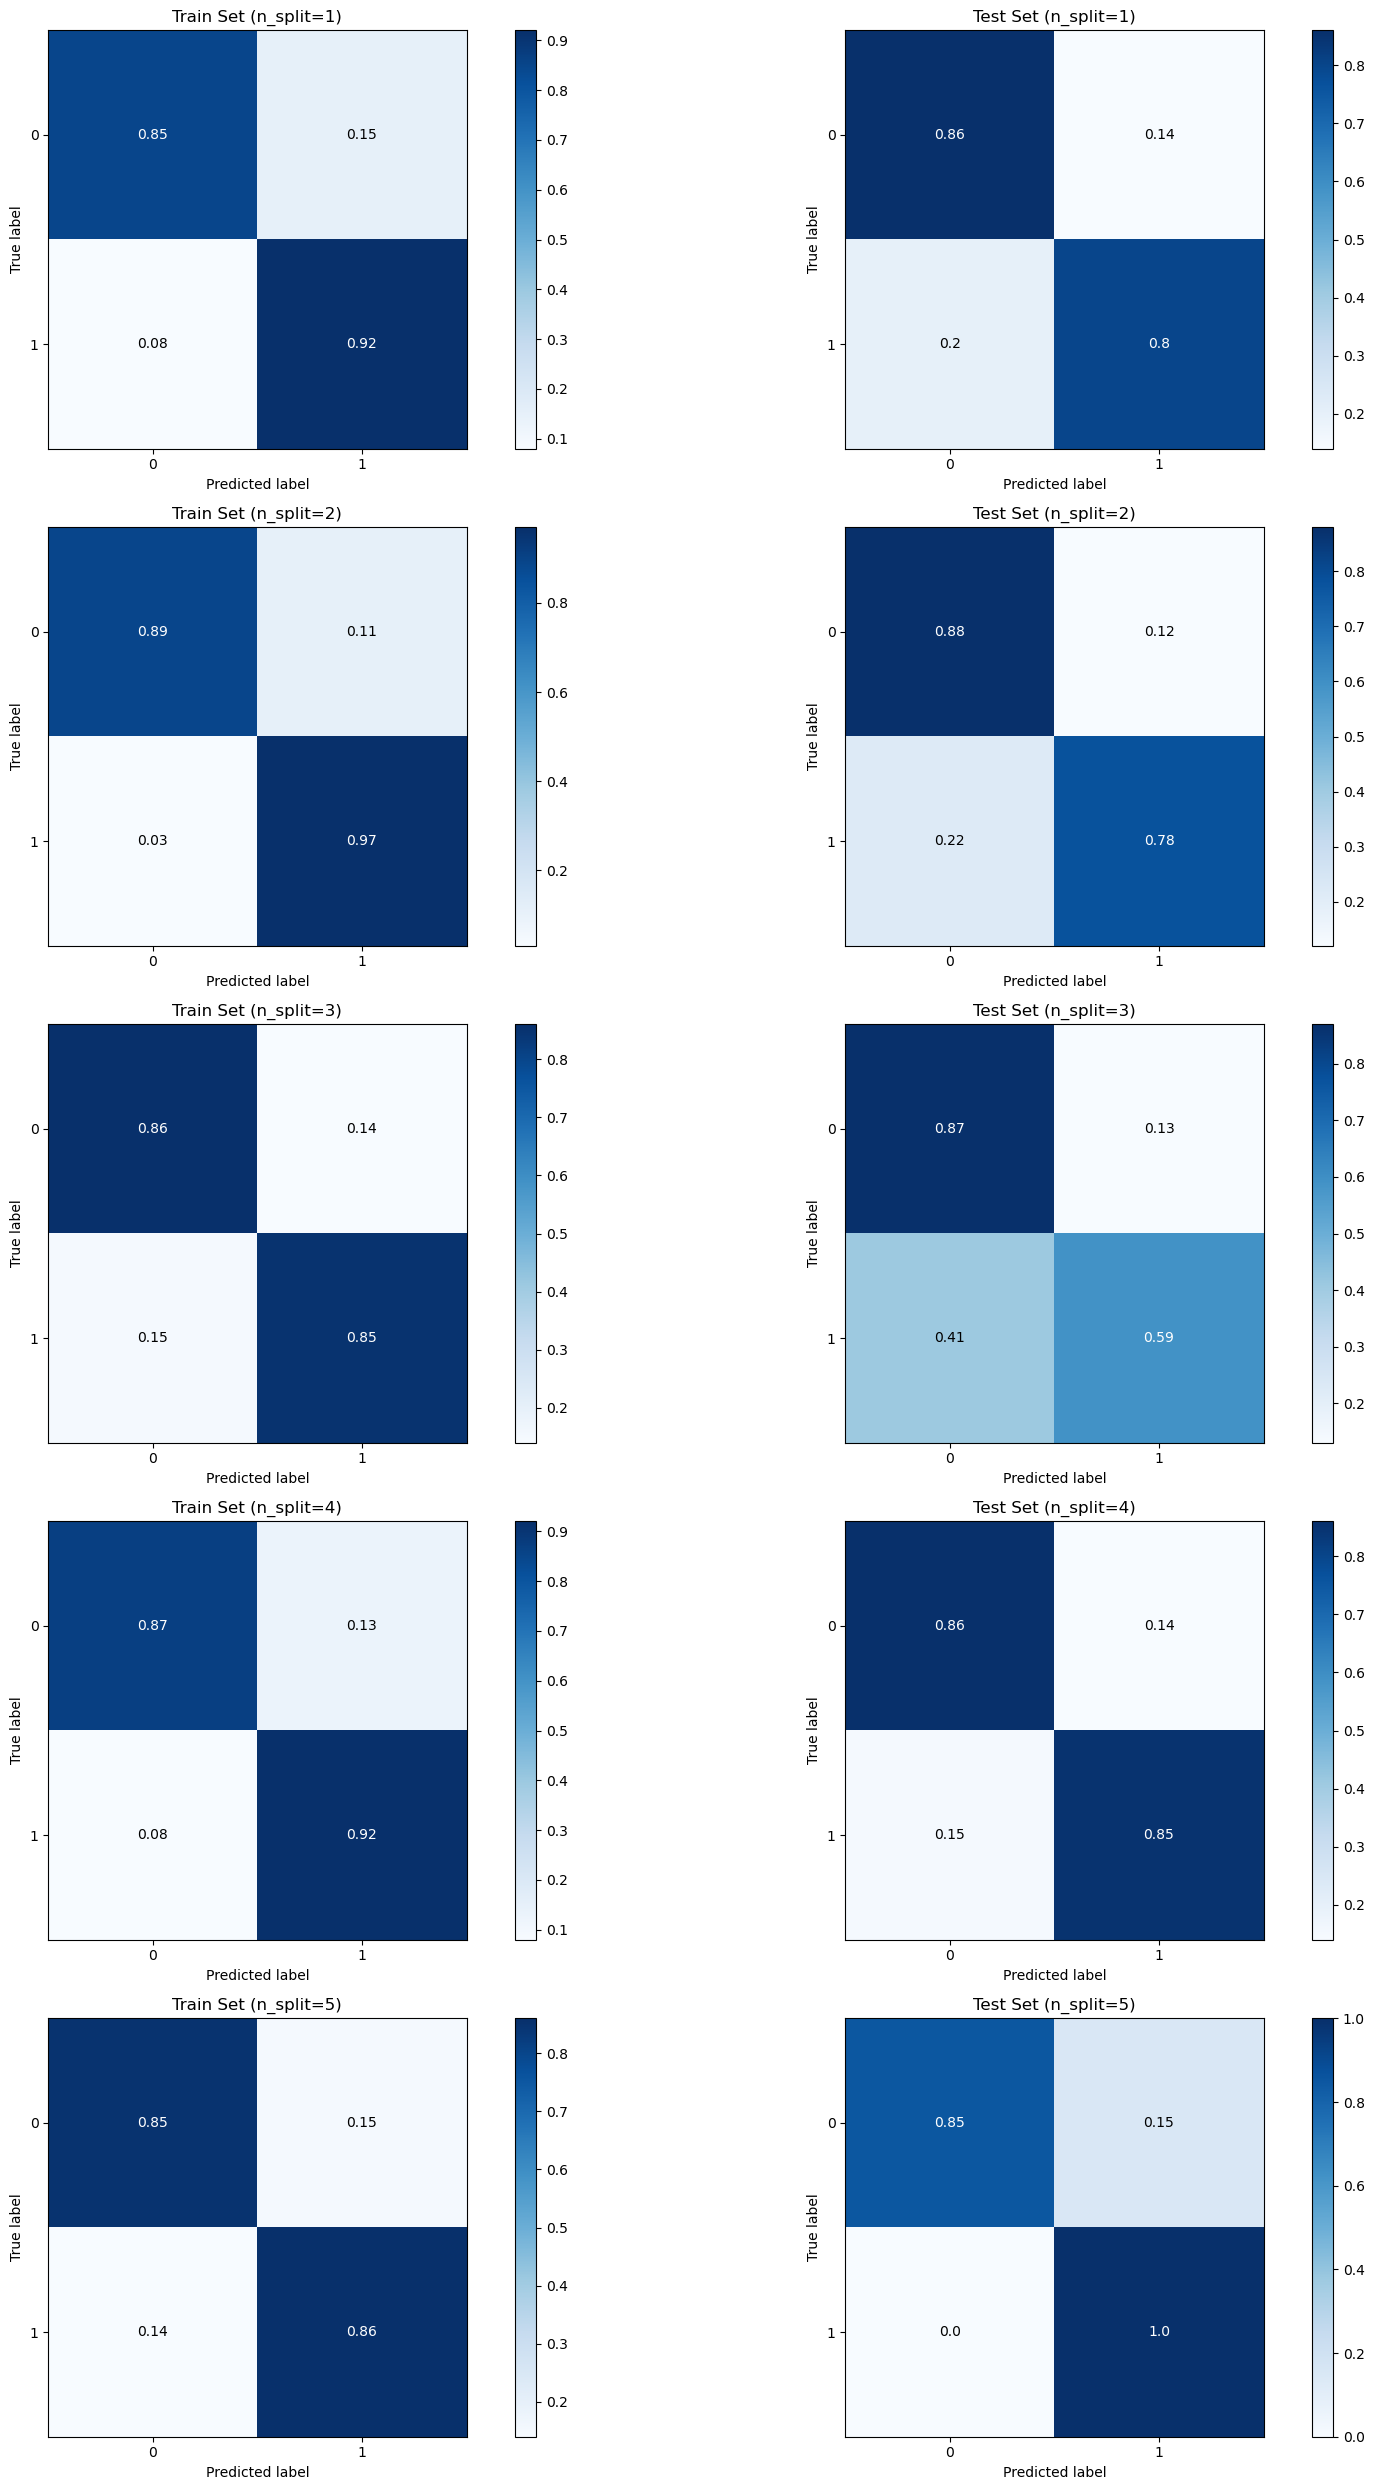

In [19]:
MyMultiTrainTester.plot_confusion(normalize=True)

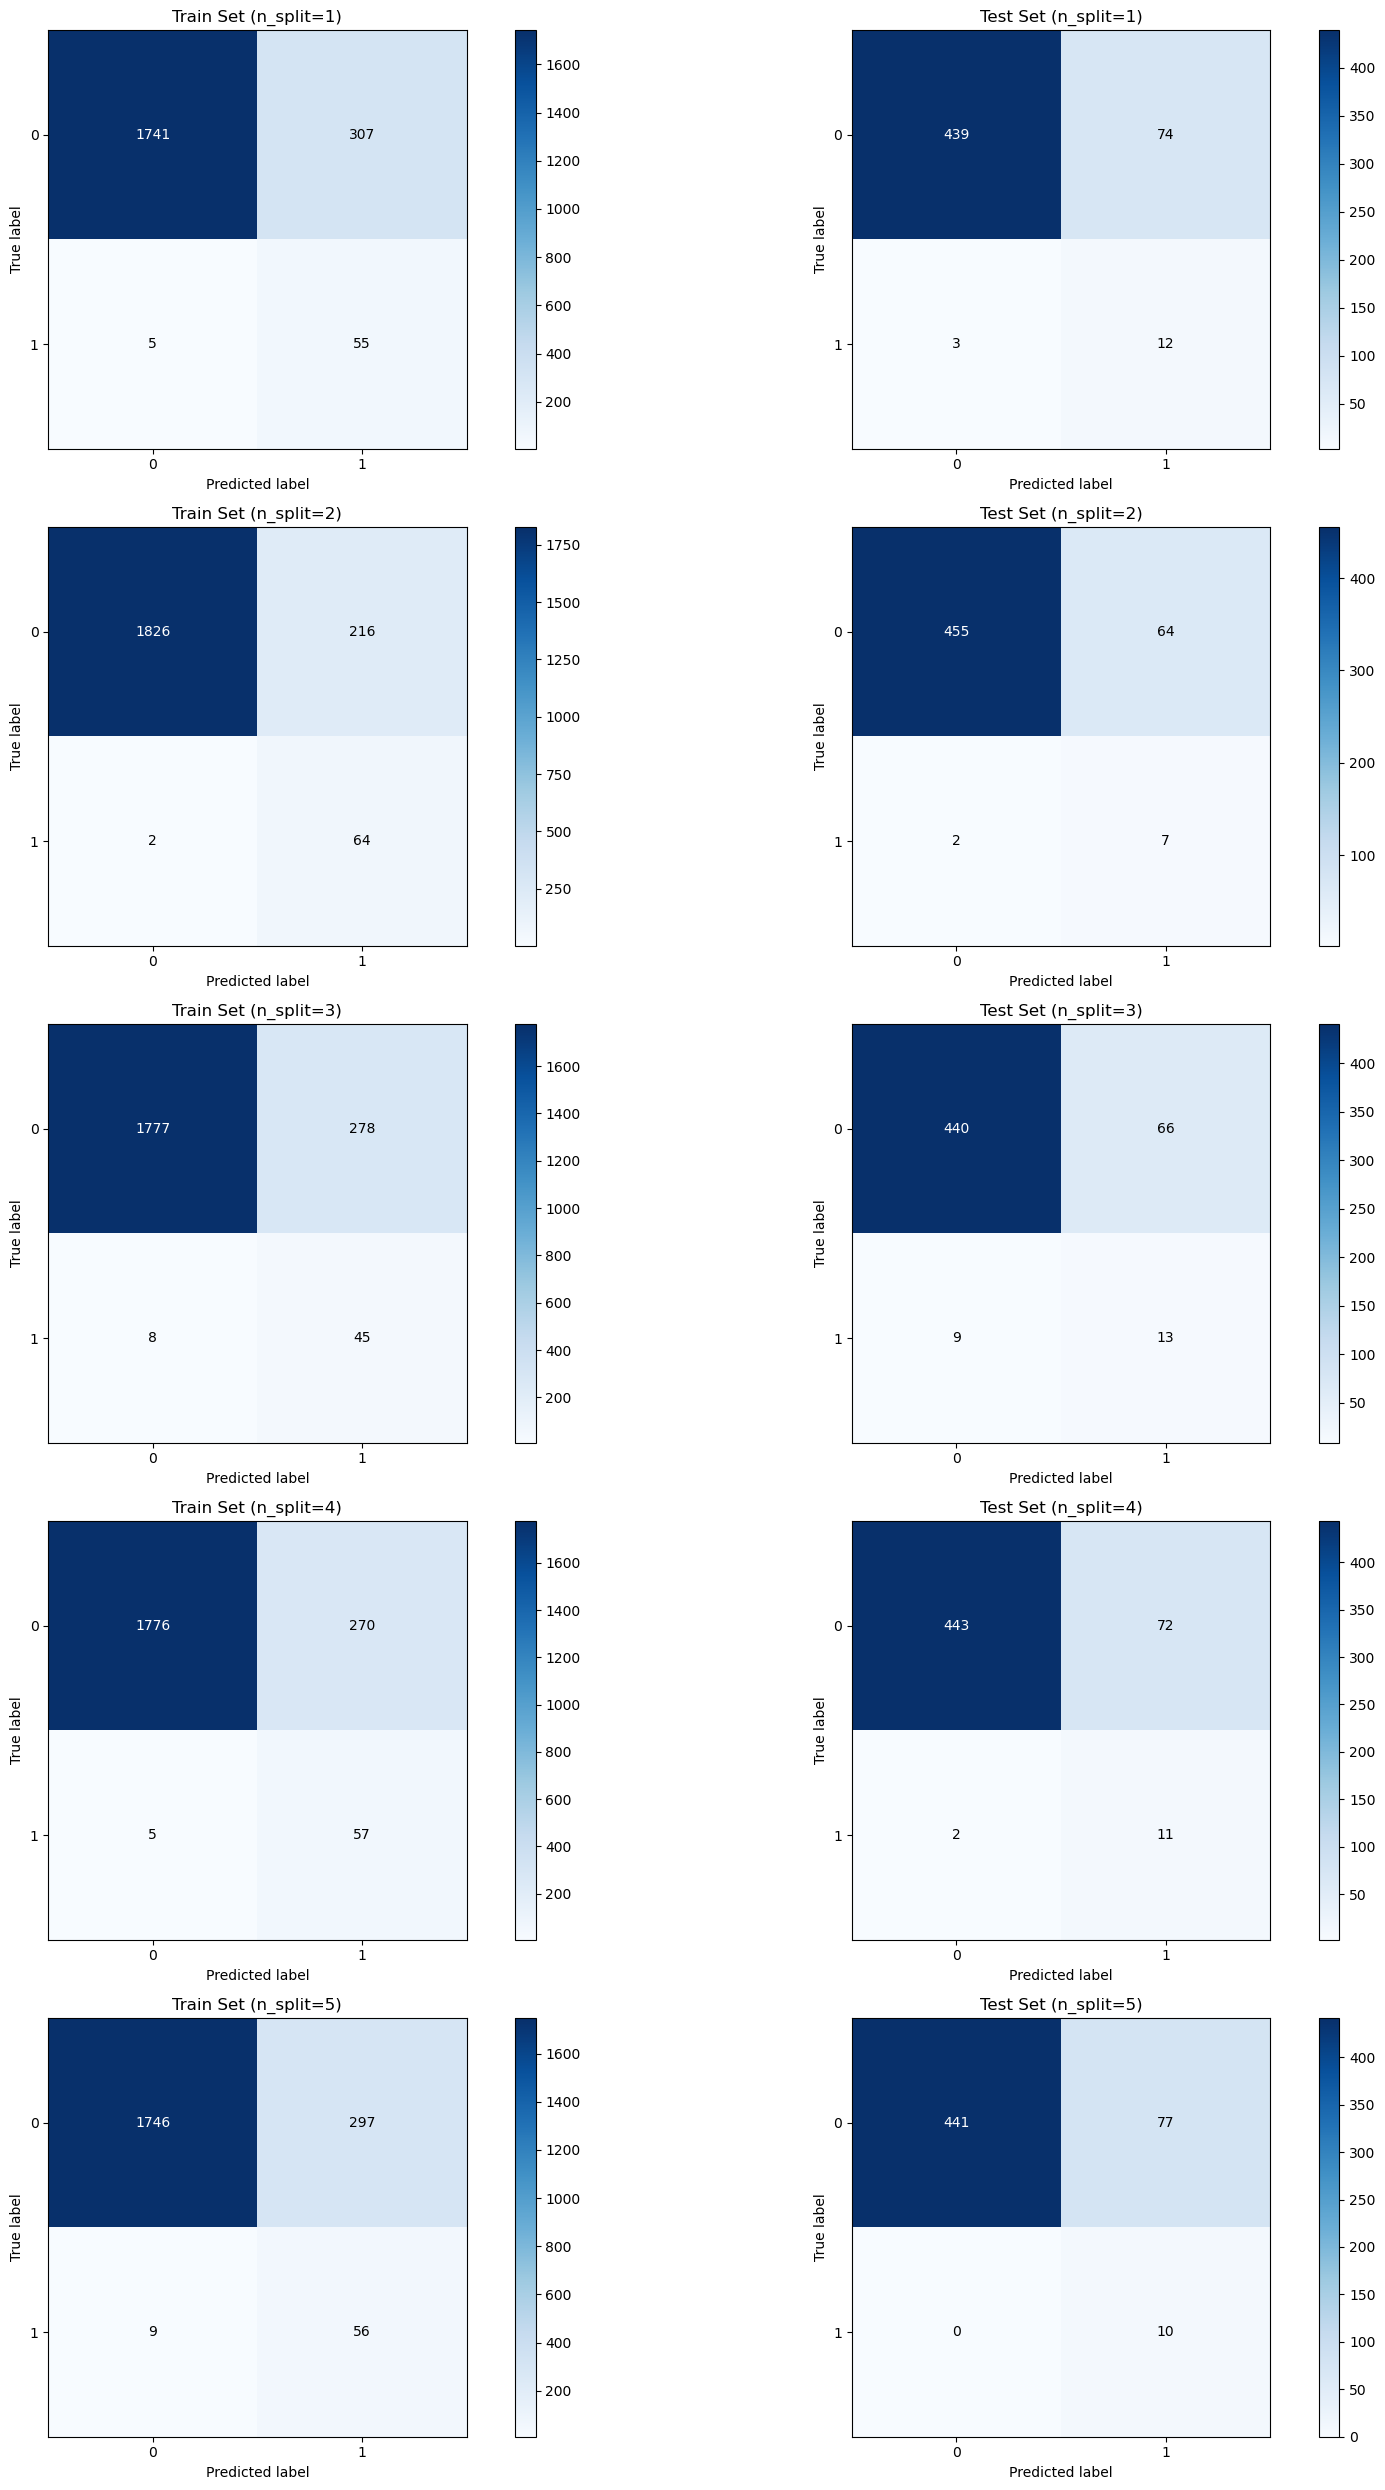

In [20]:
MyMultiTrainTester.plot_confusion(normalize=False)

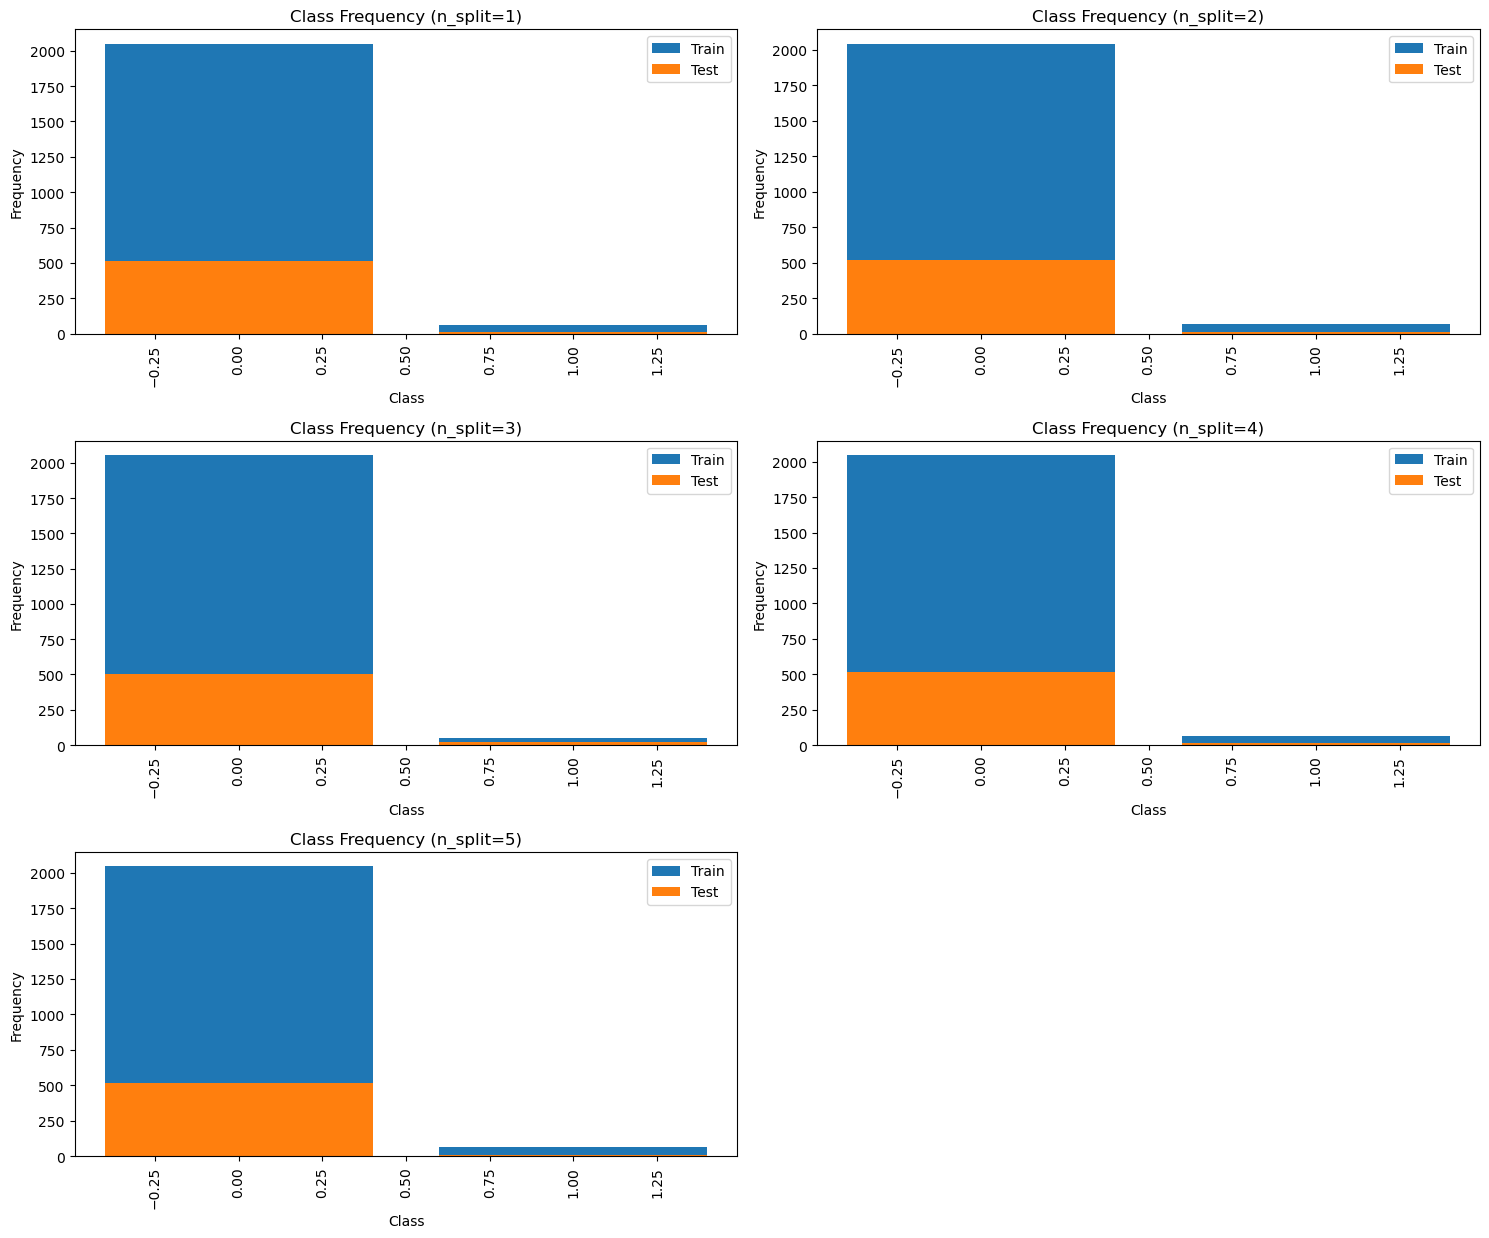

In [21]:
MyMultiTrainTester.plot_class_freq(normalize=True)

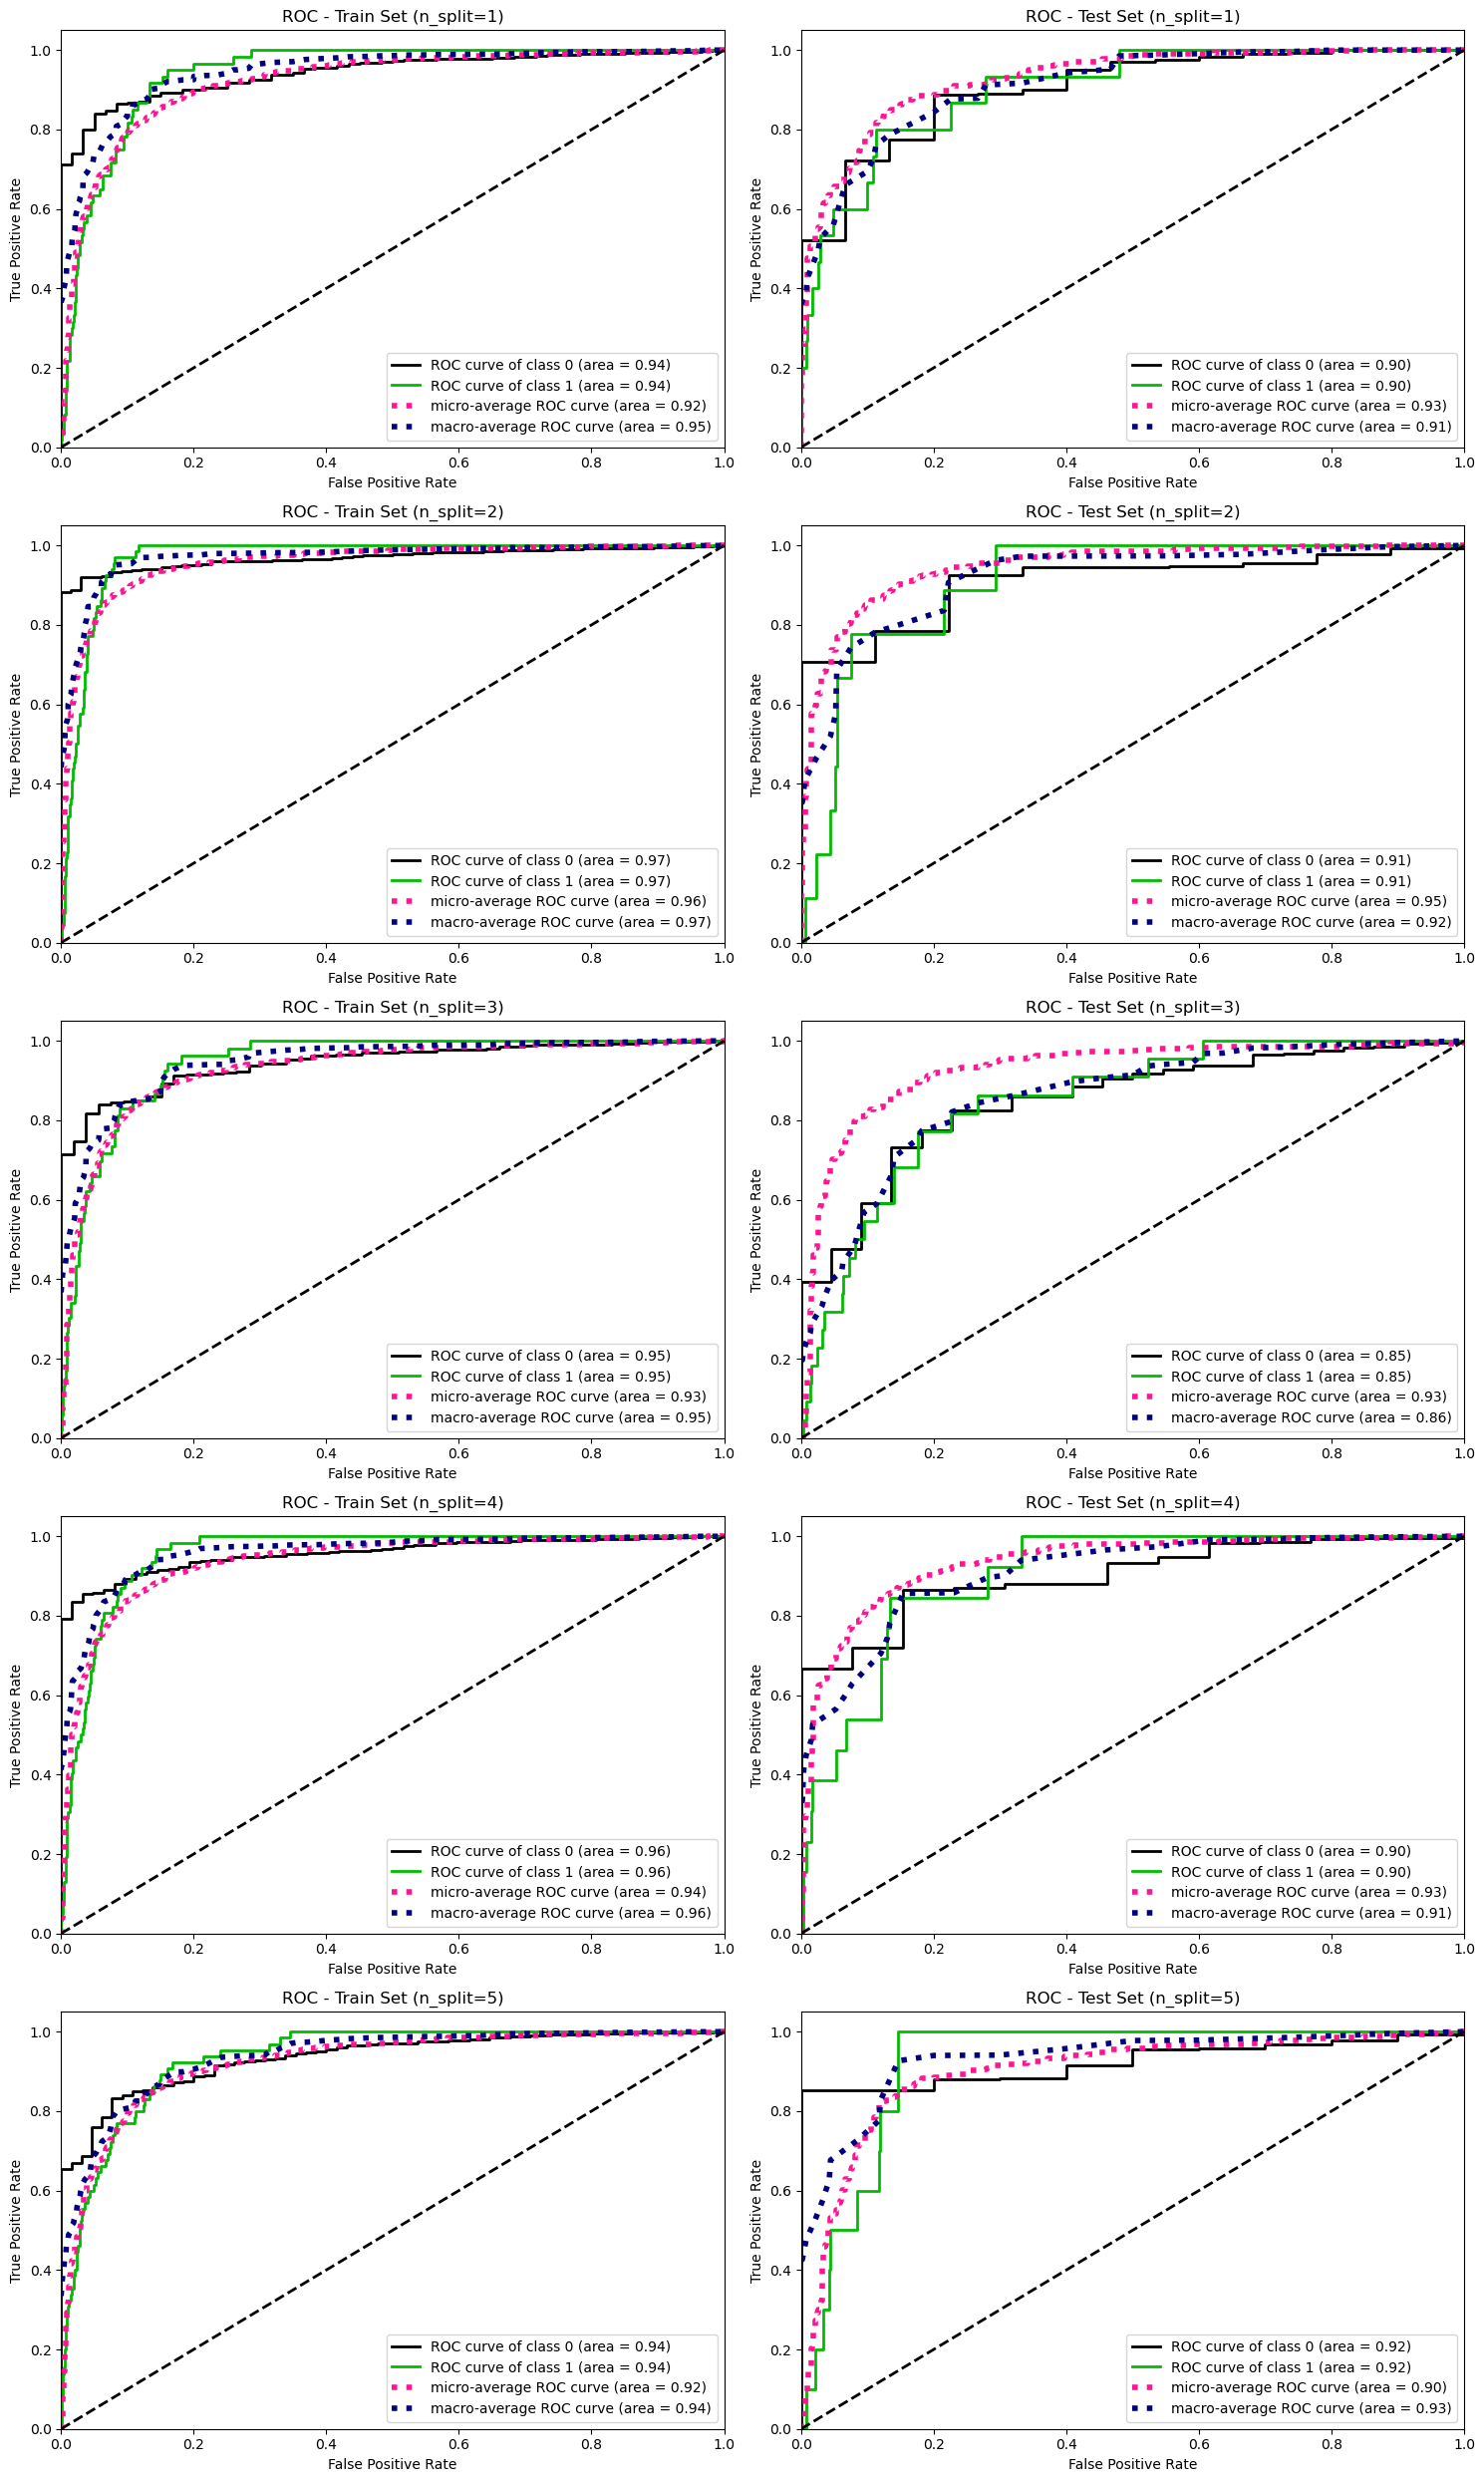

In [22]:
MyMultiTrainTester.plot_roc()

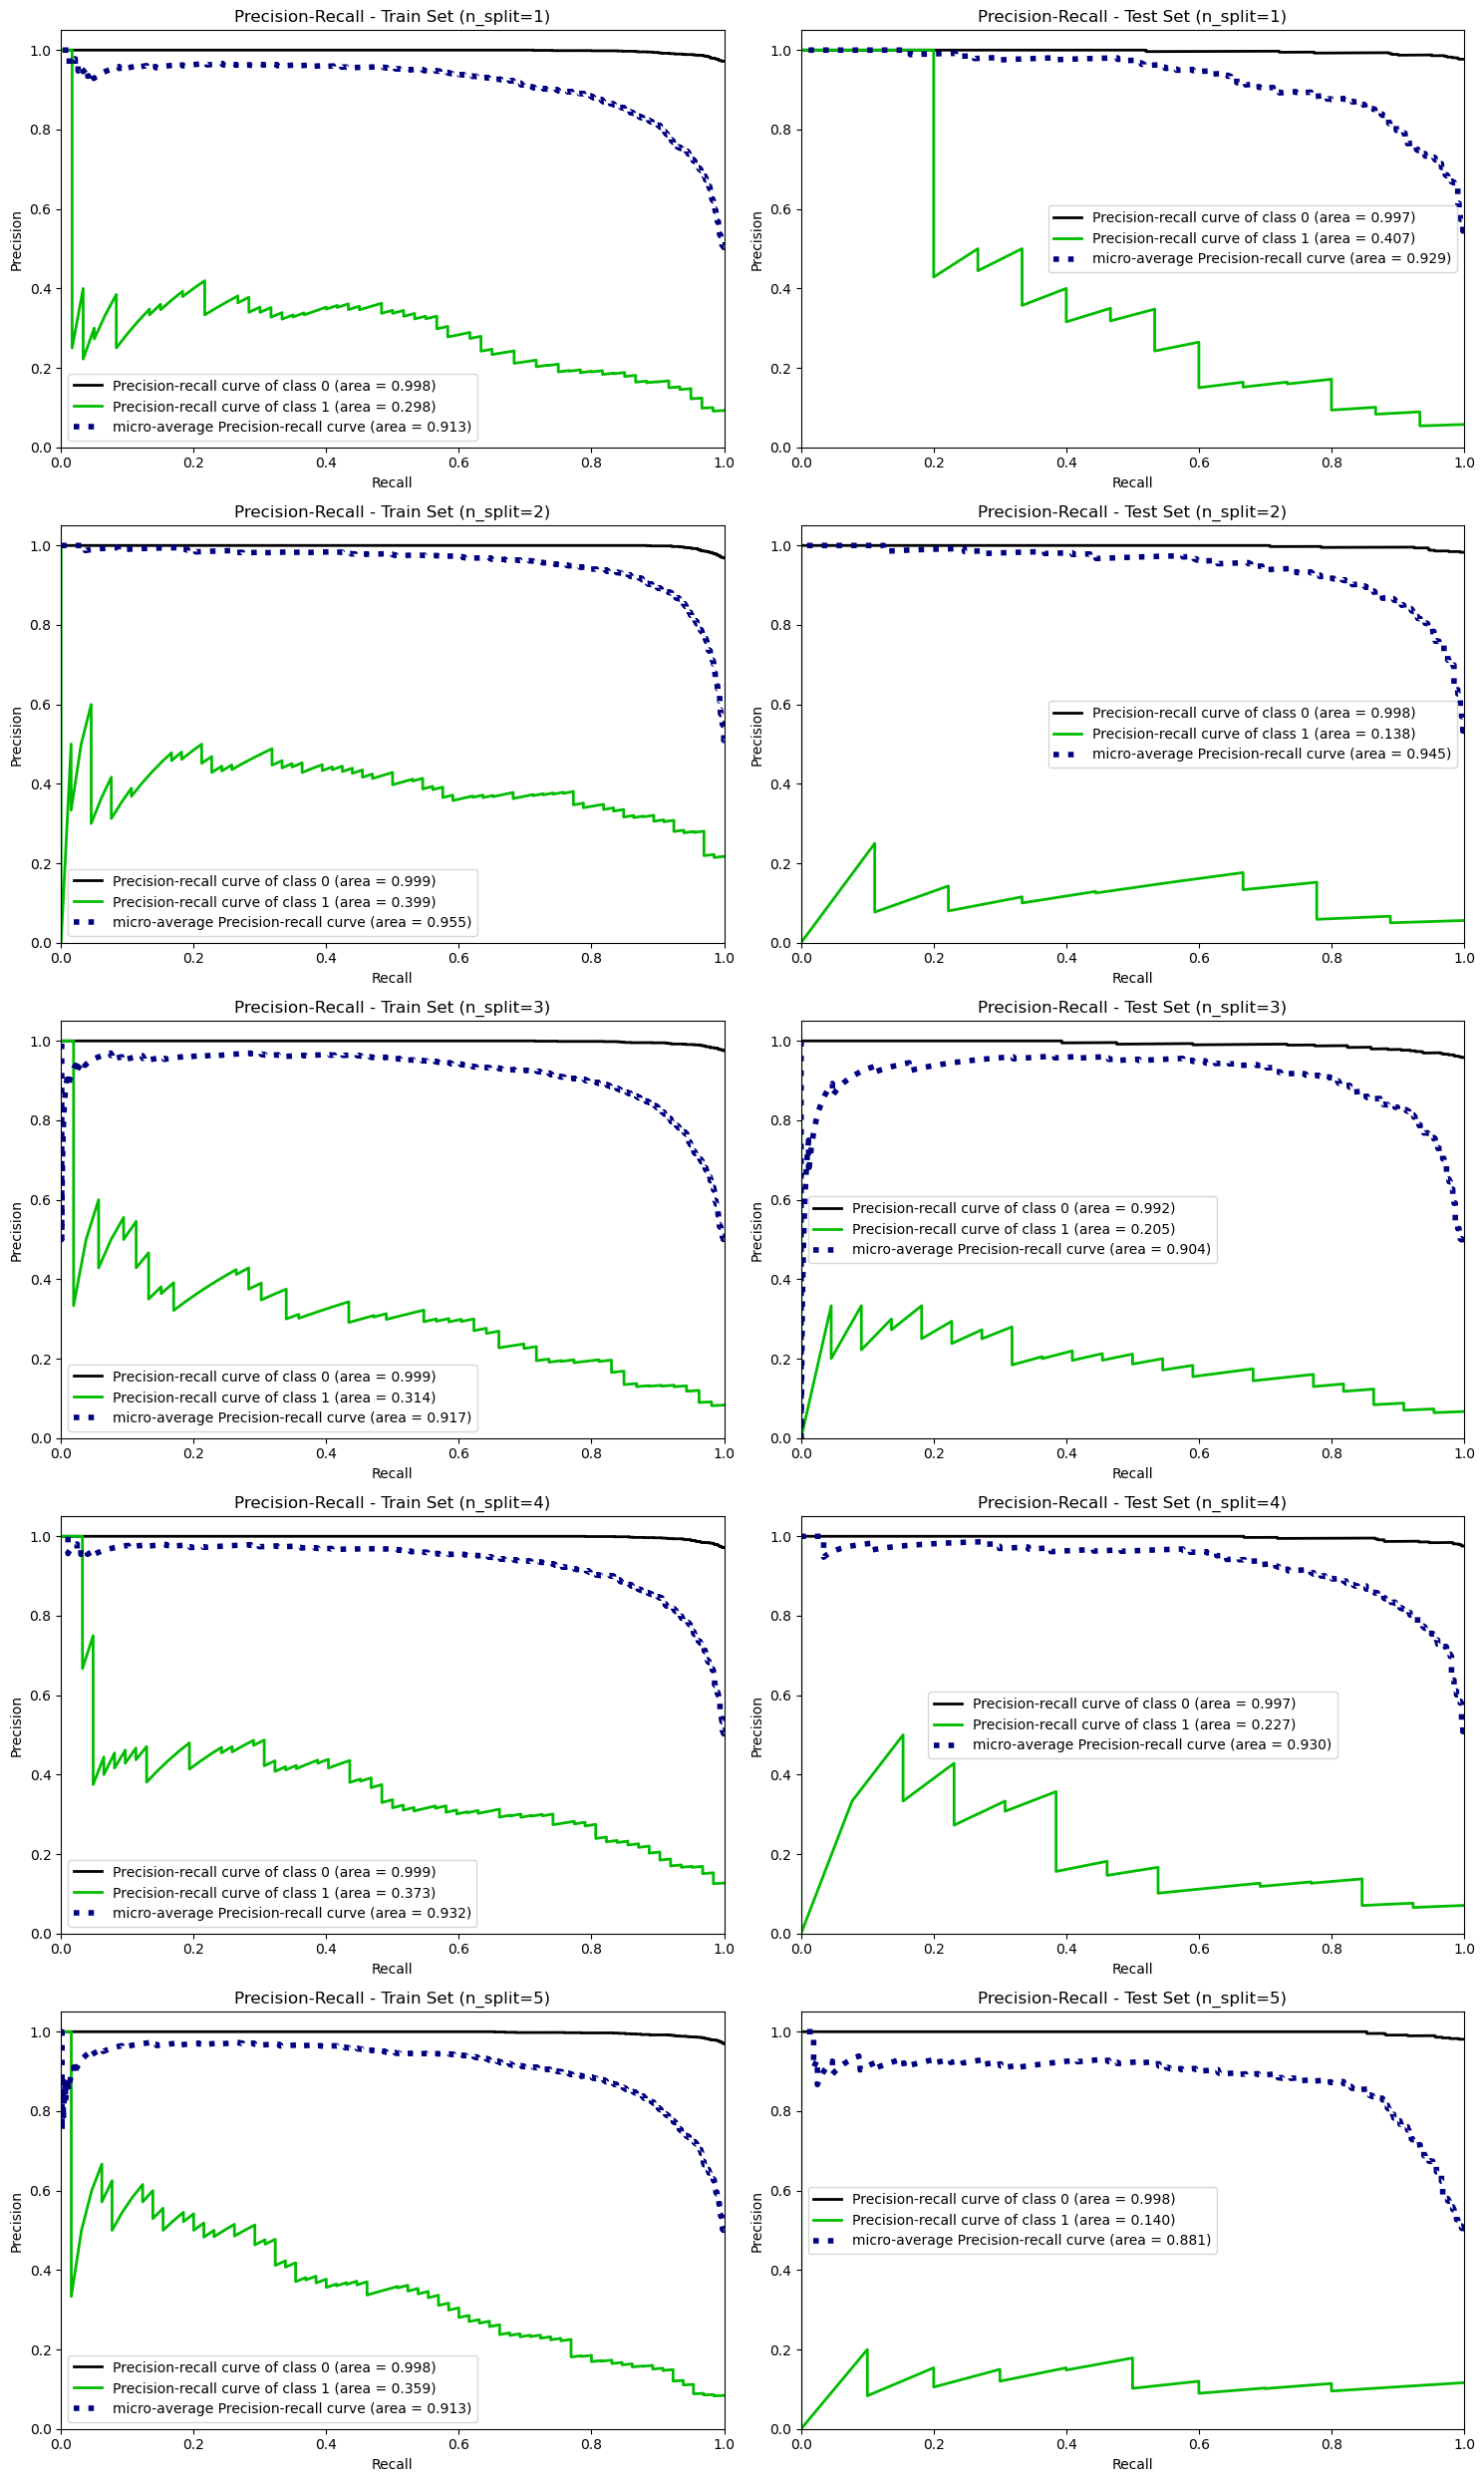

In [23]:
MyMultiTrainTester.plot_precrecall()